In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # hide non-critical warning messages


In [3]:
# Machine Learning (all from scikit-learn)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.metrics         import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, f1_score
)

In [46]:
# Display settings
pd.set_option('display.max_columns', 40)   # show all columns when printing
pd.set_option('display.float_format', '{:.3f}'.format)  # 3 decimal places
sns.set_theme(style='whitegrid')           # cleaner chart background
plt.rcParams['figure.dpi'] = 110          # sharper images

# Color shortcuts we'll reuse throughout
RED   = '#e74c3c'   # dropout students
GREEN = '#2ecc71'   # students who stayed
BLUE  = '#3498db'   # neutral/info

print(' All libraries imported!')

 All libraries imported!


In [45]:
REAL_DATA_PATH = '/content/data.csv'
df_raw = pd.read_csv(REAL_DATA_PATH, sep=';')
print(f'   File loaded successfully!')
print(f'   Rows (students):  {df_raw.shape[0]:,}')
print(f'   Columns (features): {df_raw.shape[1]}')
print()

# .head()
print('First 5 rows of the dataset:')
df_raw.head()

   File loaded successfully!
   Rows (students):  4,424
   Columns (features): 37

First 5 rows of the dataset:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.000,1,19,12,5,9,127.300,1,0,0,1,1,0,20,0,0,0,0,0,0.000,0,0,0,0,0,0.000,0,10.800,1.400,1.740,Dropout
1,1,15,1,9254,1,1,160.000,1,1,3,3,3,142.500,1,0,0,0,1,0,19,0,0,6,6,6,14.000,0,0,6,6,6,13.667,0,13.900,-0.300,0.790,Graduate
2,1,1,5,9070,1,1,122.000,1,37,37,9,9,124.800,1,0,0,0,1,0,19,0,0,6,0,0,0.000,0,0,6,0,0,0.000,0,10.800,1.400,1.740,Dropout
3,1,17,2,9773,1,1,122.000,1,38,37,5,3,119.600,1,0,0,1,0,0,20,0,0,6,8,6,13.429,0,0,6,10,5,12.400,0,9.400,-0.800,-3.120,Graduate
4,2,39,1,8014,0,1,100.000,1,37,38,9,9,141.500,0,0,0,1,0,0,45,0,0,6,9,5,12.333,0,0,6,6,6,13.000,0,13.900,-0.300,0.790,Graduate


The target is the value we are trying to predict , whether the student is going to dropout or not.We need dropout (yes/no), will change into 0/1 later.

Understanding the data so that we are aware of not using columns that leak the answer (eg : using final grade to predict dropout)
or noticing missing values that might corrupt our model.

In [47]:

# Text columns (object) must be converted — we do later.

print('Column Data Types:')
print('─' * 45)
dtype_counts = df_raw.dtypes.value_counts()
print(dtype_counts)
for dtype , count in dtype_counts.items():
    print(f'  {str(dtype):10s} → {count} columns')
#full dtypes list
print(df_raw.dtypes.to_string())



Column Data Types:
─────────────────────────────────────────────
int64      29
float64     7
object      1
Name: count, dtype: int64
  int64      → 29 columns
  float64    → 7 columns
  object     → 1 columns
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance\t                        int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                            

In [48]:
# Missing Values(NaN)
# Most ML algorithms CRASH if they encounter NaN values.
# We must either: fill them in (imputation) or remove those rows.
print('Missing Values per Column:')
print('-'*45)
missing = df_raw.isnull().sum()
missing_percent = (missing / len(df_raw) * 100)
missing_report = pd.DataFrame({'Missing Count':missing, "missing %" : missing_percent})
# this will only show the columns with missing counts > 0
missing_report = missing_report[missing_report['Missing Count']>0]
if len(missing_report) == 0:
    print(' No missing values! This dataset is clean.')
else:
    print(missing_report)
    print('\n We will handle these using SimpleImputer.')

Missing Values per Column:
---------------------------------------------
 No missing values! This dataset is clean.


In [49]:
# describe() gives  the 'shape' of each numeric column:
#   count  → how many non-missing values
#   mean   → average
#   std    → standard deviation (how spread out the values are)
#   min/max → lowest and highest value
#   25%/50%/75% → quartiles (25% of values fall below the 25% number)

In [7]:
print('Statistical Summary of Numeric Columns:')
df_raw.describe().T  # .T transposes (flips rows/cols) so it's easier to read

Statistical Summary of Numeric Columns:


,count,mean,std,min,25%,50%,75%,max
Marital status,4424.000,1.179,0.606,1.000,1.000,1.000,1.000,6.000
Application mode,4424.000,18.669,17.485,1.000,1.000,17.000,39.000,57.000
Application order,4424.000,1.728,1.314,0.000,1.000,1.000,2.000,9.000
Course,4424.000,8856.643,2063.566,33.000,9085.000,9238.000,9556.000,9991.000
Daytime/evening attendance\t,4424.000,0.891,0.312,0.000,1.000,1.000,1.000,1.000
Previous qualification,4424.000,4.578,10.217,1.000,1.000,1.000,1.000,43.000
Previous qualification (grade),4424.000,132.613,13.188,95.000,125.000,133.100,140.000,190.000
Nacionality,4424.000,1.873,6.915,1.000,1.000,1.000,1.000,109.000
Mother's qualification,4424.000,19.562,15.603,1.000,2.000,19.000,37.000,44.000
Father's qualification,4424.000,22.275,15.343,1.000,3.000,19.000,37.000,44.000


In [8]:
# Target column distribution
print('Target Column Distribution:')
print('-' *54)
target_counts = df_raw['Target'].value_counts()
print(target_counts)
for target , count in target_counts.items():
    pct = count/len(df_raw) * 100
    bar = '█' * int(pct / 2)
    print(f'  {target:12s}: {count:5,}  ({pct:.1f}%)  {bar}')

dropout_pct = target_counts.get('Dropout',0) / len(df_raw)*100
print(f'Dropout percentage: {dropout_pct:.1f}%')
if dropout_pct < 20:
  print(' Class imbalance detected — we will handle this with class_weight="balanced" in the model.')
else:
    print(' Class imbalance not detected.')


Target Column Distribution:
------------------------------------------------------
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64
  Graduate    : 2,209  (49.9%)  ████████████████████████
  Dropout     : 1,421  (32.1%)  ████████████████
  Enrolled    :   794  (17.9%)  ████████
Dropout percentage: 32.1%
 Class imbalance not detected.


# Cleaning & Prepare the Target column
Our target column has 3 values : `Dropout` , `Enrolled` , `Graduate`
Logistic Regression needs binary **0 or 1** target. So we Convert it : **Dropout =1 , everything else = 0.**

## Why binary?
Logistic Regression answers one question: *"What is the probability of THIS outcome?"*  
It can't answer "which of 3 outcomes?" without modification.  


In [9]:
df = df_raw.copy()

In [10]:
# df['Target'] == 'Dropout' creates a True/False column
# .astype(int) converts True → 1, False → 0
df['dropout'] = (df['Target'] == 'Dropout').astype(int)
df
df = df.drop('Target', axis=1)   # remove the original text column (axis=1 means column)

print('Target converted to binary:')
print(df['dropout'].value_counts().rename({0: 'Stayed (0)', 1: 'Dropped Out (1)'}).to_string())
df['dropout']


Target converted to binary:
dropout
Stayed (0)         3003
Dropped Out (1)    1421


,dropout
0,1
1,0
2,1
3,0
4,0
...,...
4419,0
4420,1
4421,1
4422,0


In [51]:
# Clean Column Names
df.columns = (
    df.columns
    .str.lower()
    .str.strip()
    .str.replace(' ', '_', regex=False)
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace('/', '', regex=False)
    .str.replace("'", '', regex=False)
)
print(f'\n Total features: {df.shape[1]-1} + 1 target')
print('\nCleaned column names:')
for col in df.columns:
    print(f'  {col}')



 Total features: 36 + 1 target

Cleaned column names:
  marital_status
  application_mode
  application_order
  course
  daytimeevening_attendance
  previous_qualification
  previous_qualification_grade
  nacionality
  mothers_qualification
  fathers_qualification
  mothers_occupation
  fathers_occupation
  admission_grade
  displaced
  educational_special_needs
  debtor
  tuition_fees_up_to_date
  gender
  scholarship_holder
  age_at_enrollment
  international
  curricular_units_1st_sem_credited
  curricular_units_1st_sem_enrolled
  curricular_units_1st_sem_evaluations
  curricular_units_1st_sem_approved
  curricular_units_1st_sem_grade
  curricular_units_1st_sem_without_evaluations
  curricular_units_2nd_sem_credited
  curricular_units_2nd_sem_enrolled
  curricular_units_2nd_sem_evaluations
  curricular_units_2nd_sem_approved
  curricular_units_2nd_sem_grade
  curricular_units_2nd_sem_without_evaluations
  unemployment_rate
  inflation_rate
  gdp
  dropout


# Exploratory Data Analysis (EDA)
EDA = Exploratory Data Analysis. Before training any model, we look at the data visually to understand patterns, relationships, and surprises.
##EDA helps you:
1. **Confirm your assumptions** about the data
2. **Spot problems** early (weird outliers, wrong data types)
3. **Find patterns** that tell you which features might matter most
4. **Tell a story** to stakeholders before showing them a model

##The most useful EDA charts
- **Histogram** — distribution of one numeric column
- **Bar chart** — counts or rates for categories
- **Box plot** — compare distributions between groups
- **Heatmap** — correlations between all features at once


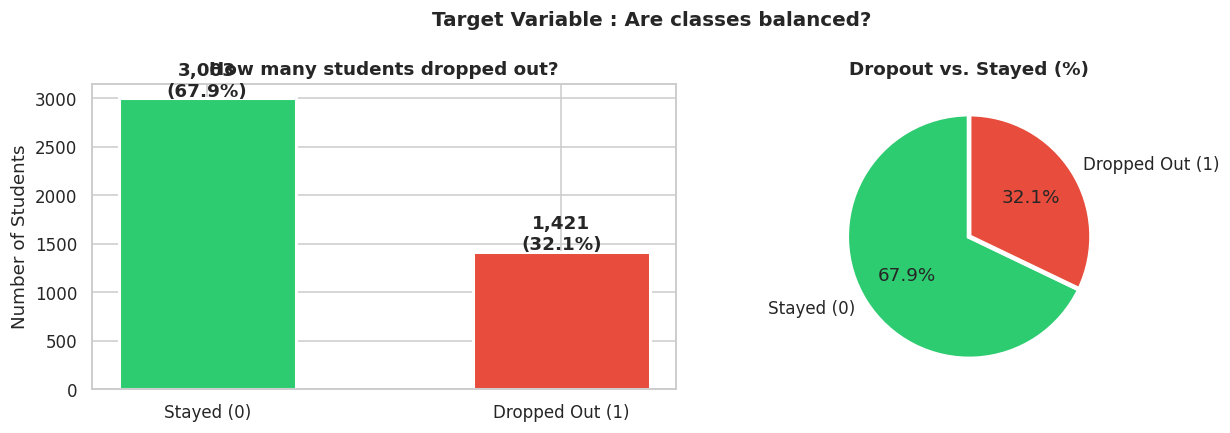


INSIGHT: If one class is <20% of data, we have class imbalance.
    We handle it by telling the model to weight the minority class higher.


In [52]:
#Target Distribution Chart ( always visualize traget variable first)
# also picture makes class imbalance obvious in a way numbers cant
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Left: Bar chart of counts
counts = df['dropout'].value_counts().sort_index()
labels = ['Stayed (0)', 'Dropped Out (1)']
bars = axes[0].bar(labels, counts.values,
                   color=[GREEN, RED], edgecolor='white', linewidth=2, width=0.5)
for bar, val in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 20,
                 f'{val:,}\n({val/len(df)*100:.1f}%)',
                 ha='center', fontweight='bold')
axes[0].set_title('How many students dropped out?', fontweight='bold')
axes[0].set_ylabel('Number of Students')

# Right: Pie chart of percentages
axes[1].pie(counts.values, labels=labels, colors=[GREEN, RED],
            autopct='%1.1f%%', startangle=90,
            wedgeprops=dict(edgecolor='white', linewidth=3))
axes[1].set_title('Dropout vs. Stayed (%)', fontweight='bold')

plt.suptitle('Target Variable : Are classes balanced?',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print('\nINSIGHT: If one class is <20% of data, we have class imbalance.')
print('    We handle it by telling the model to weight the minority class higher.')

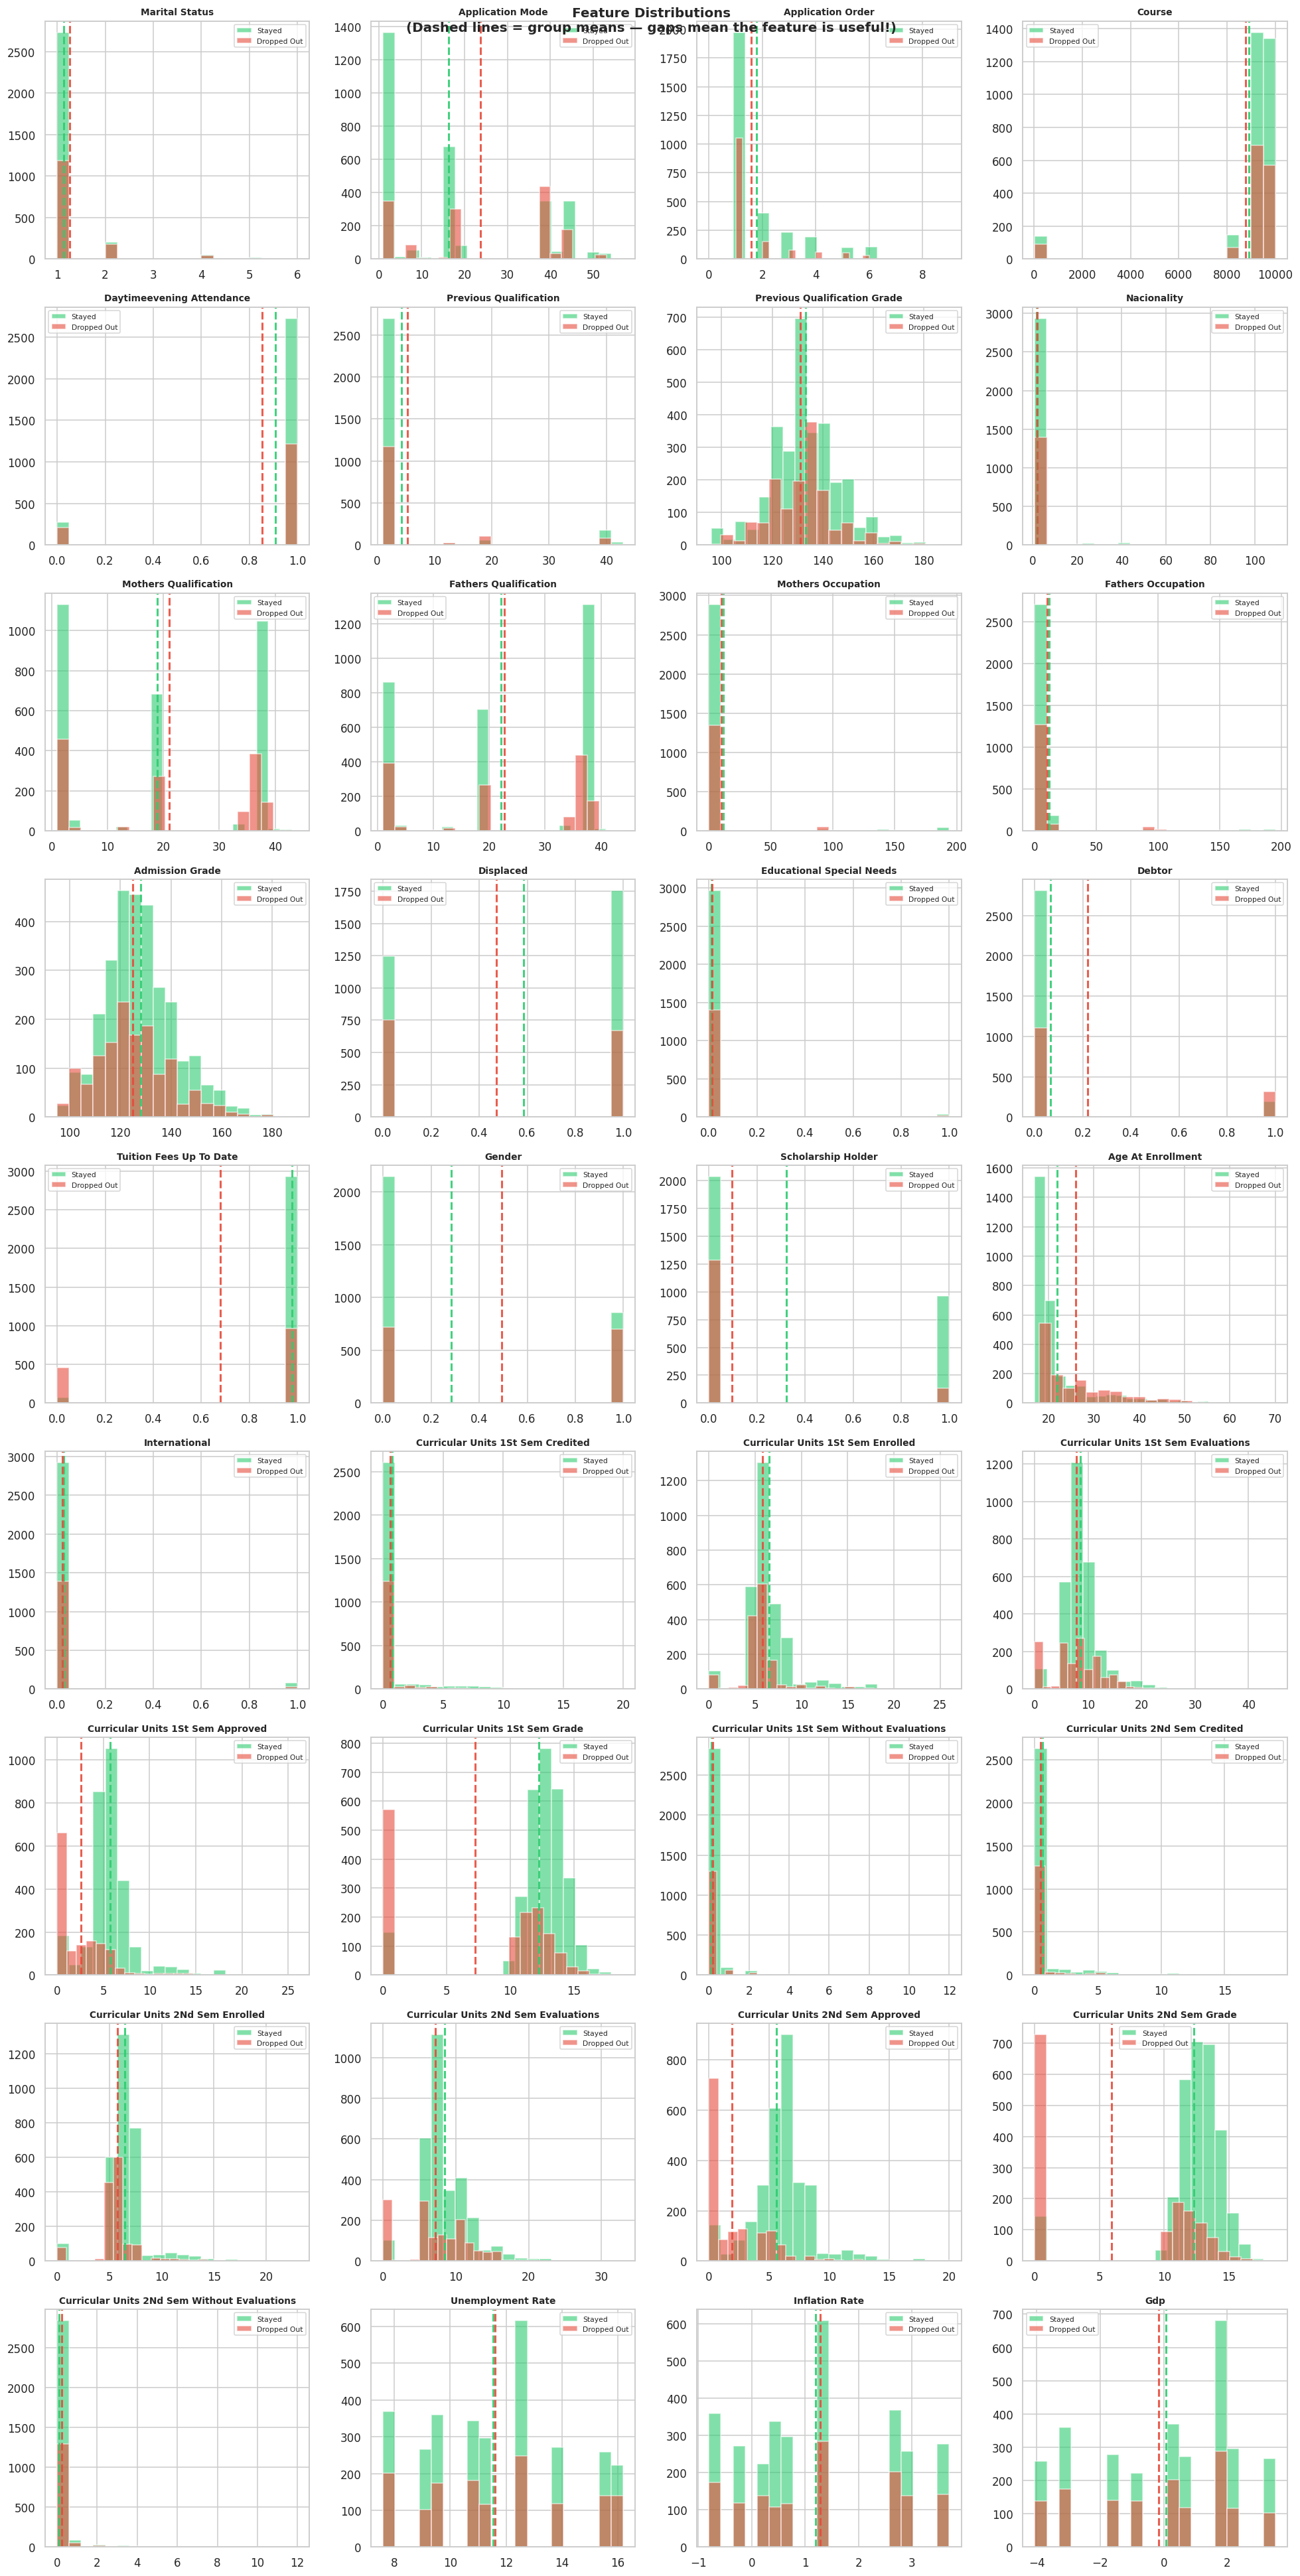

   WHAT TO LOOK FOR:
   Large gap between dashed lines → feature strongly predicts dropout
   Lines nearly overlapping       → feature might not help much


In [53]:
# ------------ Numeric Features by Dropout Status ------------
#
# We compare the DISTRIBUTION of each numeric feature
# between students who dropped out vs. those who stayed.
#
# If the distributions look DIFFERENT → that feature is useful to the model
# If they look the SAME → that feature might not help predict dropout

# Pick the most interesting numeric columns to visualize
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'dropout']

# Show up to all features
n = len(numeric_cols)
rows = (n + 3) // 4          # enough rows to fit all columns
fig, axes = plt.subplots(rows, 4, figsize=(18, rows * 4))
axes = axes.flatten()
show_cols = numeric_cols


for i, col in enumerate(show_cols): #first loop is over each feature so that each feature gets its own chart
# second loop runs exactly twice per feature — once for students who stayed (`val=0`, green)
#and once for students who dropped out (`val=1`, red).
#Both get drawn on the same chart so you can compare them.
    for val, color, label in [(0, GREEN, 'Stayed'), (1, RED, 'Dropped Out')]:
        data = df[df['dropout'] == val][col]
        axes[i].hist(data, bins=20, alpha=0.6, color=color,
                     label=label, edgecolor='white')
        # Dashed vertical line at the mean for each group
        axes[i].axvline(data.mean(), color=color,
                        linestyle='--', linewidth=2, alpha=0.9)
    axes[i].set_title(col.replace('_', ' ').title(), fontweight='bold', fontsize=9)
    axes[i].legend(fontsize=7)

plt.suptitle('Feature Distributions\n(Dashed lines = group means — gaps mean the feature is useful!)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('   WHAT TO LOOK FOR:')
print('   Large gap between dashed lines → feature strongly predicts dropout')
print('   Lines nearly overlapping       → feature might not help much')

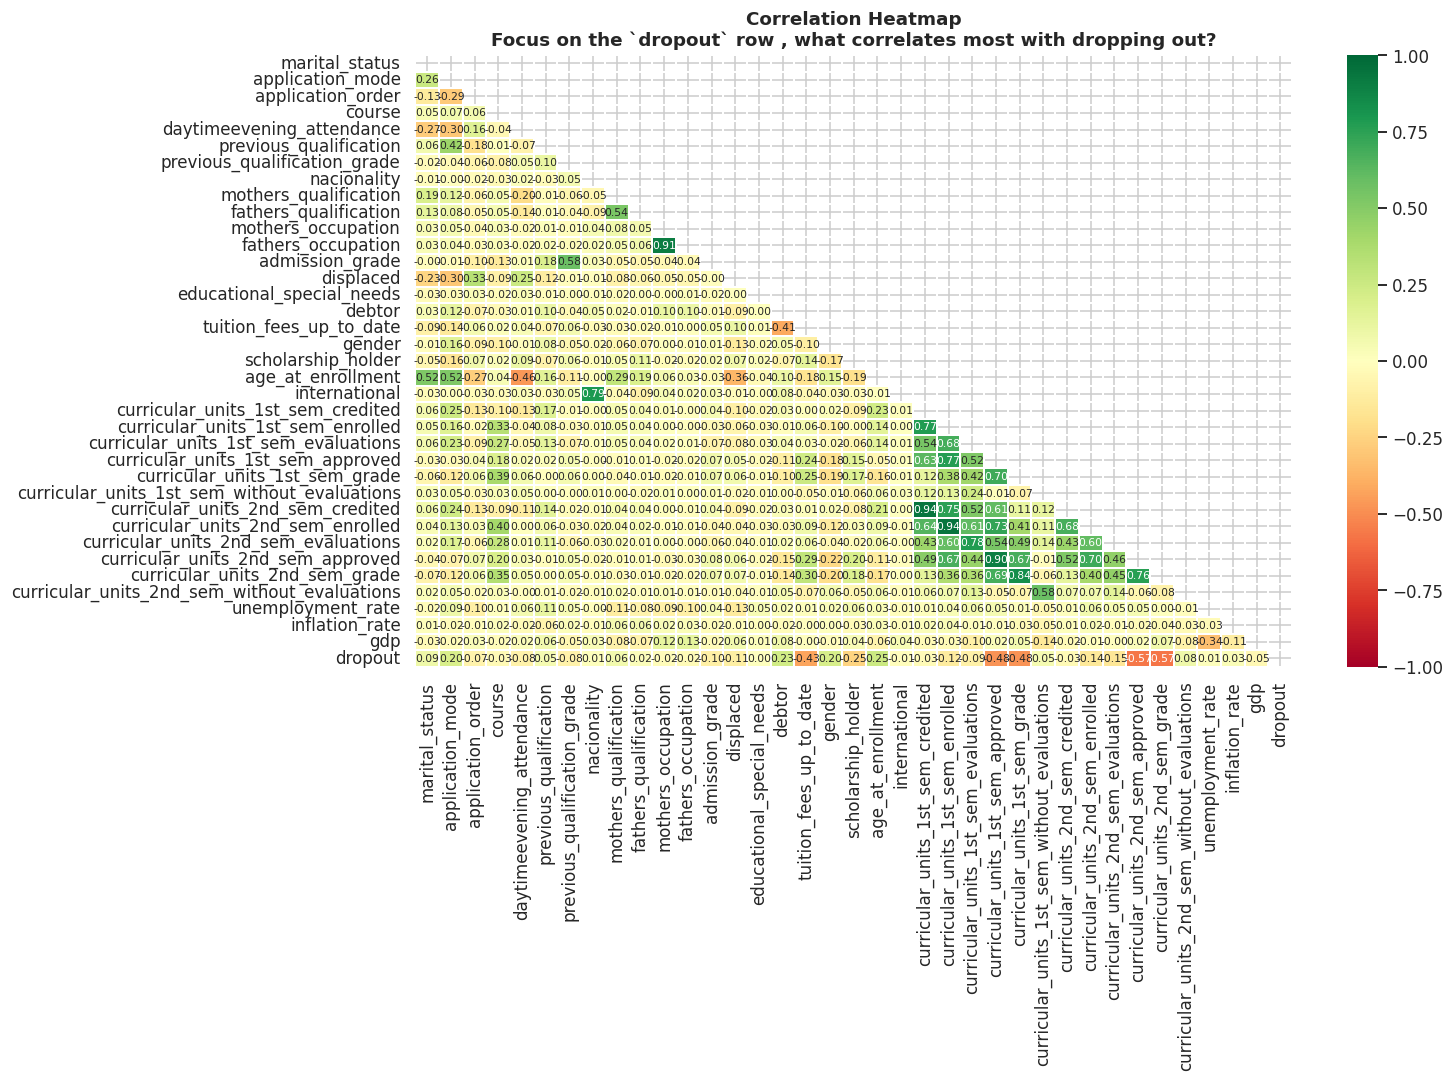


 Top 10 features most correlated with dropout:
   1. curricular_units_2nd_sem_grade               : -0.572  (⬇ negative)
   2. curricular_units_2nd_sem_approved            : -0.570  (⬇ negative)
   3. curricular_units_1st_sem_grade               : -0.481  (⬇ negative)
   4. curricular_units_1st_sem_approved            : -0.479  (⬇ negative)
   5. tuition_fees_up_to_date                      : -0.429  (⬇ negative)
   6. age_at_enrollment                            : +0.254  (⬆ positive)
   7. scholarship_holder                           : -0.245  (⬇ negative)
   8. debtor                                       : +0.229  (⬆ positive)
   9. gender                                       : +0.204  (⬆ positive)
  10. application_mode                             : +0.198  (⬆ positive)


In [54]:
# Correlation Heatmap
#correlation measures how well two variable move together , if +1 both move up, -1 one up and another down , 0 no relation at all
#coorelaton !=  cause

df_numeric = df.select_dtypes(include=np.number)

plt.figure(figsize=(14, 10))
corr_matrix = df_numeric.corr()

# mask=np.triu hides the upper triangle (it's a mirror of the lower)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask,
    annot=True, fmt='.2f',        # show correlation numbers in each cell
    cmap='RdYlGn',                # red=negative, yellow=zero, green=positive
    center=0, vmin=-1, vmax=1,
    linewidths=0.3,
    annot_kws={'size': 7}
)
plt.title('Correlation Heatmap\nFocus on the `dropout` row , what correlates most with dropping out?',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Print top correlations with dropout, sorted
print('\n Top 10 features most correlated with dropout:')
dropout_corr = corr_matrix['dropout'].drop('dropout').abs().sort_values(ascending=False)
for i, (feat, val) in enumerate(dropout_corr.head(10).items(), 1):
    raw_corr = corr_matrix['dropout'][feat]
    direction = '⬆ positive' if raw_corr > 0 else '⬇ negative'
    print(f'  {i:2d}. {feat:45s}: {raw_corr:+.3f}  ({direction})')


#Separate Features (X) and Target (y)
In machine learning, we always split the data into:
- **X** (features / inputs) — everything the model is allowed to look at
- **y** (target / output) — what the model has to predict

X is a matrix (2D — rows and columns), y is a vector (1D — just one column). In math, matrices are uppercase and vectors are lowercase. Sklearn follows this convention — always use X and y.

In [55]:
#seperate X and y
y = df["dropout"]
# X is all the other columns except dropout
X = df.drop('dropout',axis = 1)


We need to know which columns are numeric and which are categorical
because they need different preprocessing treatments:


*   Numeric     → StandardScaler (make them same scale)
*   Categorical → OneHotEncoder (convert text to numbers)

#### Our data has everything in numerical for convinence

In [60]:
numeric_features     = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print(f'Numeric Features: {numeric_features}')
print(f'Categorical Features: {categorical_features}')
print(f'Features (X): {X.shape[1]} columns, {X.shape[0]:,} rows')
print(f'   Target (y):   {y.shape[0]:,} values')


Numeric Features: ['marital_status', 'application_mode', 'application_order', 'course', 'daytimeevening_attendance', 'previous_qualification', 'previous_qualification_grade', 'nacionality', 'mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation', 'admission_grade', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'age_at_enrollment', 'international', 'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations', 'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations', 'unemployment_rate', 'inflation_rate', 'gdp']
Categorical Features: []
Features (X

#Splitting our data into training and test set
- **Training set (80%)** — the model learns from this
- **Test set (20%)** — we evaluate our the model on this (it never sees this during training)

## What is `stratify=y`?
Without stratify, we might randomly get a test set with very few dropout cases.
`stratify=y` ensures the **dropout rate is the same in both train and test sets**.
This is especially important when classes are imbalanced.

## What is `random_state=42`?
The split is random, but `random_state` fixes the random seed so:
- We always get the **same split** when we re-run
- Others can **reproduce our exact results**
(42 is a convention — any number works)

In [59]:
X_train ,X_test, y_train,y_test = train_test_split(
    X,                  # features
    y,                  # target
    test_size=0.20,     # 20% goes to test set, 80% to training
    random_state=42,    # fix the random seed for reproducibility
    stratify=y          # keep the same dropout % in both sets
)


In [61]:
print('Data split complete!')
print(f'\n  Training set:  {X_train.shape[0]:,} students ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'  Test set:      {X_test.shape[0]:,} students  ({X_test.shape[0]/len(X)*100:.0f}%)')
print()
print('  Dropout rates (stratify is working if these match):')
print(f'    Full dataset:   {y.mean()*100:.2f}%')
print(f'    Training set:   {y_train.mean()*100:.2f}%')
print(f'    Test set:       {y_test.mean()*100:.2f}%')
print()
print('The dropout rates should be nearly identical confirming stratify worked.')

Data split complete!

  Training set:  3,539 students (80%)
  Test set:      885 students  (20%)

  Dropout rates (stratify is working if these match):
    Full dataset:   32.12%
    Training set:   32.13%
    Test set:       32.09%

The dropout rates should be nearly identical confirming stratify worked.


#Build a Preprocessing Pipeline

##  What is preprocessing?
Raw data can't go directly into a machine learning model.  
It needs to be **transformed** first. Two critical transformations:

### 1. StandardScaler (for numeric features)
Different features have wildly different scales:
- `age` → 17 to 35
- `curricular_units_approved` → 0 to 26
- `admission_grade` → 0 to 200

Logistic Regression uses math that adds all features together.  
Without scaling, `admission_grade` (up to 200) would dominate `age` (up to 35)  
just because of its scale — not because it's actually more important.

StandardScaler converts every feature to: **mean=0, std=1**

### 2. OneHotEncoder (for categorical features)
Models understand numbers, not text.  
A column like `gender: ['Male', 'Female']` becomes two columns:  
`gender_Male: [1, 0]` and `gender_Female: [0, 1]`

## Why use a Pipeline instead of doing it manually?

**The data leakage problem:** If we scale our data BEFORE splitting into train/test,
the scaler has 'seen' the test data (its min/max/mean) during fitting.

A Pipeline applies transformations **inside** cross-validation, so the scaler
only ever sees training data. This gives  honest results.

In [62]:

# ------Numeric Transformer-------------
# Pipeline chains steps in order: first impute, then scale
# SimpleImputer: fills missing values with the median of that column
# Why median? It's more robust to outliers than the mean.
# StandardScaler: subtracts mean, divides by std
# Result: every numeric feature has mean=0, std=1

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])


# -----Categorical Transformer ---------
#
# SimpleImputer: fills missing text values with the most common value
# OneHotEncoder: converts text categories to 0/1 columns
#   handle_unknown='ignore' → if test data has a new category we
#   never saw in training, don't crash — just put 0s

if categorical_features:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    transformers = [
        ('num', numeric_transformer,     numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
else:
    transformers = [
        ('num', numeric_transformer, numeric_features)
    ]

# ------ColumnTransformer----------
#
# Applies DIFFERENT transformers to DIFFERENT columns simultaneously.
#   numeric columns  → go to numeric_transformer
#   text columns     → go to categorical_transformer
preprocessor = ColumnTransformer(transformers=transformers)

# -------Full Pipeline (Preprocessor + Model)------
#
# The final pipeline chains:
#   1. preprocessor → cleans and transforms all features
#   2. LogisticRegression → the actual ML model
#
# When we call pipeline.fit(X_train, y_train):
#   → preprocessor fits AND transforms X_train
#   → LogisticRegression trains on the transformed data
#
# When you call pipeline.predict(X_test):
#   → preprocessor transforms X_test (using params from training only!)
#   → LogisticRegression predicts

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',   LogisticRegression(
        max_iter=2000,         # max iterations for the solver to converge
        random_state=42,       # reproducibility
        class_weight='balanced' # give more weight to minority class (dropout)
    ))
])

print('Pipeline built!')
print('Pipeline structure:')
print('─' * 50)
print('  [1] preprocessor (ColumnTransformer)')
if categorical_features:
    print(f'        |---  numeric  ({len(numeric_features)} cols) → Imputer → StandardScaler')
    print(f'        |---  categorical ({len(categorical_features)} cols) → Imputer → OneHotEncoder')
else:
    print(f'       |--- numeric ({len(numeric_features)} cols) → Imputer → StandardScaler')
print('  [2] LogisticRegression')
print('─' * 50)

Pipeline built!
Pipeline structure:
──────────────────────────────────────────────────
  [1] preprocessor (ColumnTransformer)
       |--- numeric (36 cols) → Imputer → StandardScaler
  [2] LogisticRegression
──────────────────────────────────────────────────


# Train the Model

## What is Logistic Regression?
Logistic Regression is a **classification** algorithm (not regression).  
It learns to predict the **probability** that a student will drop out.
values will be in is it greater than threshold or less than threshold
## How does it  work?
It learns a formula:
```
log_odds = w1×GPA + w2×attendance + w3×depression_score + ... + bias
probability = 1 / (1 + e^(-log_odds))   ← sigmoid function
```

During **training**, it adjusts the weights (w1, w2, w3...) until the formula  
predicts dropout correctly as often as possible.

## What does `.fit()`  do?
`.fit(X_train, y_train)` runs the training process:
1. Start with random weights.
2. Make a prediction with those weights.
3. Calculate how wrong it was (loss).
4. Adjust weights to reduce the loss.
5. Repeat thousands of times until weights stop improving.

## Cross-Validation
After training, we run **5-Fold Cross-Validation** to check performance more reliably.  
It splits training data into 5 chunks, trains on 4, validates on 1, repeats 5 times.  
This gives 5 scores which we average. Much more reliable than a single train/test split.

In [63]:
pipeline.fit(X_train, y_train)
print("model trained")
#  Quick check on training data(not real eval)
train_accuracy = pipeline.score(X_train, y_train)
print(f'  Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)')
print('  (Training accuracy is always optimistic — test accuracy is what counts)')
print()
# 5-Fold Cross Validation
#
# StratifiedKFold ensures each fold has the same dropout rate
# This gives us 5 scores - we report the mean and std
#
# std (standard deviation) tells us how consistent the model is:
#   low std → model performs similarly on all folds (stable )
#   high std → model is sensitive to which data it sees (unstable )
print('Running 5-Fold Cross Validation on training data...')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
cv_auc      = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
cv_f1       = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')

print()
print('  5-Fold CV Results (on training data):')
print(f'    Accuracy:  {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}  {[f"{s:.3f}" for s in cv_accuracy]}')
print(f'    AUC-ROC:   {cv_auc.mean():.4f} ± {cv_auc.std():.4f}  {[f"{s:.3f}" for s in cv_auc]}')
print(f'    F1-Score:  {cv_f1.mean():.4f} ± {cv_f1.std():.4f}  {[f"{s:.3f}" for s in cv_f1]}')
print()
print(' The ± number is the standard deviation. Smaller = more consistent model.')

model trained
  Training accuracy: 0.8692 (86.92%)
  (Training accuracy is always optimistic — test accuracy is what counts)

Running 5-Fold Cross Validation on training data...

  5-Fold CV Results (on training data):
    Accuracy:  0.8647 ± 0.0160  ['0.846', '0.869', '0.879', '0.846', '0.884']
    AUC-ROC:   0.9148 ± 0.0112  ['0.901', '0.910', '0.931', '0.908', '0.925']
    F1-Score:  0.7944 ± 0.0215  ['0.775', '0.791', '0.816', '0.768', '0.822']

 The ± number is the standard deviation. Smaller = more consistent model.


#Evaluate the Model
##  5 metrics we must measure

### 1. Accuracy
```
Accuracy = Correct predictions / Total predictions
```
**Problem:** If 70% of students stayed, a model that always predicts 'stayed' gets 70% accuracy -> not useful.

### 2. Confusion Matrix
A 2×2 table showing 4 types of predictions:
```
                    Predicted: Stayed    Predicted: Dropped
Actually: Stayed  →  True Negative (TN)   False Positive (FP)  ← wrongly flagged
Actually: Dropped →  False Negative (FN)  True Positive (TP)   ← correctly caught
                          ↑ missed dropout!
```
In our case, **False Negatives are costly** - we missed a student who needed help.

### 3. Precision
Of all students we predicted as dropout, how many actually dropped out?  
`Precision = TP / (TP + FP)`

### 4. Recall (Sensitivity)
Of all students who actually dropped out, how many did we catch?  
`Recall = TP / (TP + FN)` → "Did we find all the at-risk students?"

**For dropout prediction, Recall matters more than Precision.**  
Missing a dropout (FN) is worse than a false alarm (FP).

### 5. AUC-ROC
Measures how well the model ranks students by risk (0.5=random, 1.0=perfect).  
Unaffected by class imbalance -> the most reliable single metric here.

In [64]:
# -----Make Predictions-----
# predict()       → gives class labels (0 or 1)
# predict_proba() → gives probabilities (e.g., [0.23, 0.77])
#                   [:, 1] takes the second column = P(dropout=1)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]


acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
f1  = f1_score(y_test, y_pred)

print('=' * 60)
print('  BASELINE MODEL PERFORMANCE (Test Set)')
print('=' * 60)
print(f'  Accuracy:   {acc:.4f} ({acc*100:.2f}%)')
print(f'  AUC-ROC:    {auc:.4f}  ← most important metric here')
print(f'  F1-Score:   {f1:.4f}')
print()
print('  Full Classification Report:')
print('  (precision, recall, f1-score for each class)')
print()
print(classification_report(y_test, y_pred, target_names=['Stayed (0)', 'Dropped Out (1)']))

# baseline scores for comparison
baseline_acc = acc
baseline_auc = auc
baseline_f1  = f1

  BASELINE MODEL PERFORMANCE (Test Set)
  Accuracy:   0.8734 (87.34%)
  AUC-ROC:    0.9272  ← most important metric here
  F1-Score:   0.8082

  Full Classification Report:
  (precision, recall, f1-score for each class)

                 precision    recall  f1-score   support

     Stayed (0)       0.92      0.89      0.91       601
Dropped Out (1)       0.79      0.83      0.81       284

       accuracy                           0.87       885
      macro avg       0.85      0.86      0.86       885
   weighted avg       0.88      0.87      0.87       885



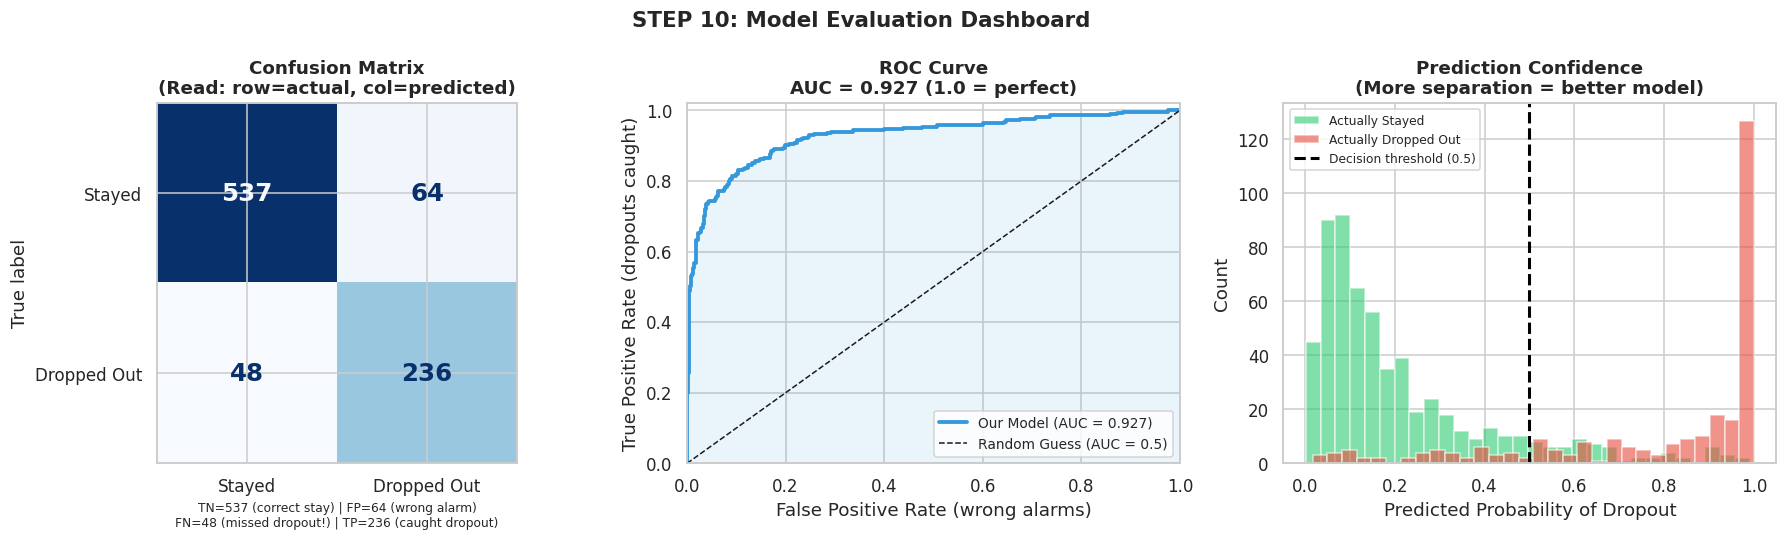

In [35]:
# ---- Visualize the Metrics-----
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# ----Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Stayed', 'Dropped Out']).plot(
    ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Confusion Matrix\n(Read: row=actual, col=predicted)', fontweight='bold')
for text in axes[0].texts:
    text.set_fontsize(16); text.set_fontweight('bold')
tn, fp, fn, tp = cm.ravel()
axes[0].set_xlabel(
    f'TN={tn} (correct stay) | FP={fp} (wrong alarm)\n'
    f'FN={fn} (missed dropout!) | TP={tp} (caught dropout)',
    fontsize=8
)

# ----- ROC Curve ------
#
# ROC curve plots True Positive Rate vs False Positive Rate
# at every possible decision threshold.
# The AREA under this curve (AUC) is our performance summary.
# Closer to top-left corner = better model.
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, color=BLUE, lw=2.5,
             label=f'Our Model (AUC = {auc:.3f})')
axes[1].plot([0,1],[0,1], 'k--', lw=1, label='Random Guess (AUC = 0.5)')
axes[1].fill_between(fpr, tpr, alpha=0.1, color=BLUE)
axes[1].set_xlabel('False Positive Rate (wrong alarms)')
axes[1].set_ylabel('True Positive Rate (dropouts caught)')
axes[1].set_title(f'ROC Curve\nAUC = {auc:.3f} (1.0 = perfect)', fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].set_xlim([0,1]); axes[1].set_ylim([0,1.02])

# ---- Probability Distribution ------
#
# This shows HOW CONFIDENT the model is in its predictions.
# Well-separated peaks = model clearly distinguishes the two groups.
# Overlapping histograms = model is confused in the middle range.
axes[2].hist(y_prob[y_test==0], bins=30, alpha=0.6,
             color=GREEN, label='Actually Stayed', edgecolor='white')
axes[2].hist(y_prob[y_test==1], bins=30, alpha=0.6,
             color=RED, label='Actually Dropped Out', edgecolor='white')
axes[2].axvline(0.5, color='black', lw=2, linestyle='--',
                label='Decision threshold (0.5)')
axes[2].set_xlabel('Predicted Probability of Dropout')
axes[2].set_ylabel('Count')
axes[2].set_title('Prediction Confidence\n(More separation = better model)', fontweight='bold')
axes[2].legend(fontsize=8)

plt.suptitle('STEP 10: Model Evaluation Dashboard', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# STEP 12 — Feature Importance

After training, we can look **inside** the model to see which features it weighted most heavily.
This is what turns a model into **business insight**.

## Coefficients vs. Odds Ratios

**Coefficients** are what the model actually learned:
- Positive → feature increases dropout risk
- Negative → feature decreases dropout risk
- Larger absolute value → more influential

**Odds Ratios** = `exp(coefficient)` — easier to explain to non-technical people:
- OR = 2.0 → this feature **doubles** the odds of dropout
- OR = 0.5 → this feature **halves** the odds of dropout
- OR = 1.0 → no effect at all


In [38]:
# ── FEATURE IMPORTANCE ───────────────────────────────────────
# We extract the weights (coefficients) the model learned
# during training — these tell us which features matter most

# Step 1: Pull the trained LogisticRegression out of the pipeline
trained_lr = pipeline.named_steps['classifier']

# Step 2: Pull the preprocessor to get the final feature names
# (after OneHotEncoding, new columns were created — we need their names)
preprocessor_fitted = pipeline.named_steps['preprocessor']

try:
    feature_names_out = preprocessor_fitted.get_feature_names_out()
    feature_names_clean = [
        name.replace('num__', '').replace('cat__', '').replace('bin__', '')
        for name in feature_names_out
    ]
except:
    # fallback if get_feature_names_out() doesn't work
    feature_names_clean = numeric_features

# Step 3: Build a DataFrame of coefficients
coef_df = pd.DataFrame({
    'Feature':     feature_names_clean,
    'Coefficient': trained_lr.coef_[0],
    'Odds_Ratio':  np.exp(trained_lr.coef_[0]),
    'Abs_Coef':    np.abs(trained_lr.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

# Step 4: Print the top 15
print('Top 15 Most Influential Features:')
print('─' * 70)
print(f'{"Feature":45s} {"Coefficient":>12s} {"Odds Ratio":>12s}')
print('─' * 70)
for _, row in coef_df.head(15).iterrows():
    arrow = '⬆ increases risk' if row['Coefficient'] > 0 else '⬇ reduces risk'
    print(f'{row["Feature"]:45s} {row["Coefficient"]:>+12.4f} {row["Odds_Ratio"]:>10.3f}x  {arrow}')

Top 15 Most Influential Features:
──────────────────────────────────────────────────────────────────────
Feature                                        Coefficient   Odds Ratio
──────────────────────────────────────────────────────────────────────
curricular_units_2nd_sem_approved                  -1.8264      0.161x  ⬇ reduces risk
curricular_units_1st_sem_approved                  -0.9232      0.397x  ⬇ reduces risk
curricular_units_2nd_sem_enrolled                  +0.8236      2.279x  ⬆ increases risk
tuition_fees_up_to_date                            -0.7188      0.487x  ⬇ reduces risk
curricular_units_2nd_sem_credited                  +0.5056      1.658x  ⬆ increases risk
international                                      -0.3526      0.703x  ⬇ reduces risk
mothers_occupation                                 -0.3415      0.711x  ⬇ reduces risk
age_at_enrollment                                  +0.3410      1.406x  ⬆ increases risk
nacionality                                       

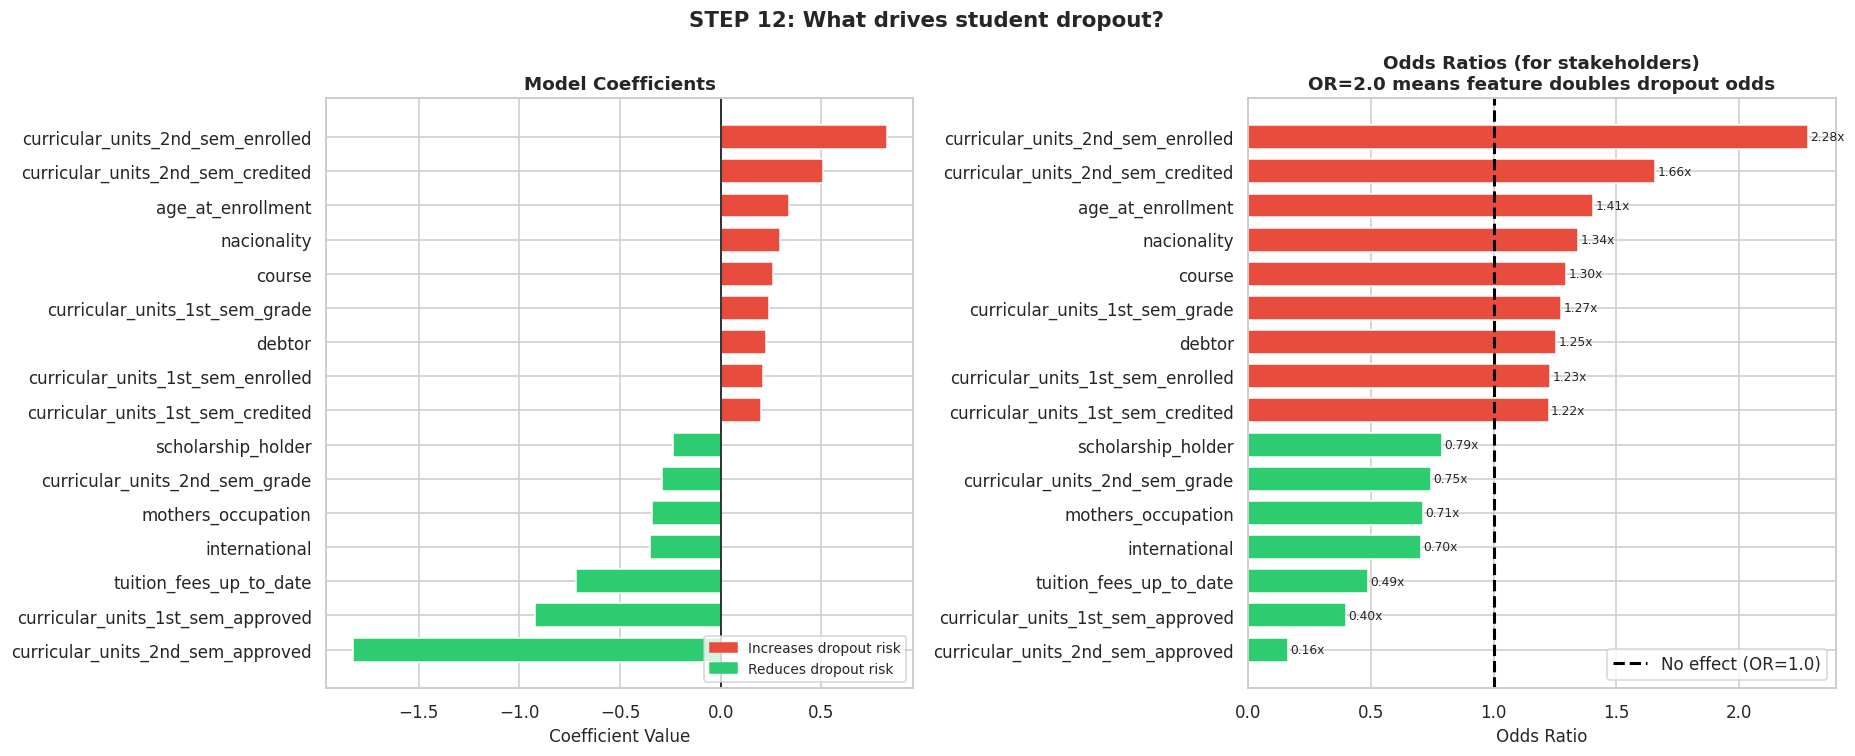

In [66]:
# ── Visualize Feature Importance ──────────────────────────────────────

top_n  = min(16, len(coef_df))
top_df = coef_df.head(top_n).sort_values('Coefficient')

fig, axes = plt.subplots(1, 2, figsize=(17, 7))

# Left: Coefficient bar chart
bar_colors = [RED if c > 0 else GREEN for c in top_df['Coefficient']]
axes[0].barh(top_df['Feature'], top_df['Coefficient'],
             color=bar_colors, edgecolor='white', height=0.7)
axes[0].axvline(0, color='black', lw=1)
axes[0].set_xlabel('Coefficient Value', fontsize=11)

import matplotlib.patches as mpatches

axes[0].set_title('Model Coefficients', fontweight='bold', fontsize=12)

# Create a manual legend with colored boxes
red_patch   = mpatches.Patch(color=RED,   label='Increases dropout risk')
green_patch = mpatches.Patch(color=GREEN, label='Reduces dropout risk')
axes[0].legend(handles=[red_patch, green_patch],
               loc='lower right', fontsize=9)

# Right: Odds Ratio chart
top_or = coef_df.head(top_n).sort_values('Odds_Ratio')
or_colors = [RED if o > 1 else GREEN for o in top_or['Odds_Ratio']]
axes[1].barh(top_or['Feature'], top_or['Odds_Ratio'],
             color=or_colors, edgecolor='white', height=0.7)
axes[1].axvline(1.0, color='black', lw=2, linestyle='--',
                label='No effect (OR=1.0)')
axes[1].set_xlabel('Odds Ratio', fontsize=11)
axes[1].set_title(
    'Odds Ratios (for stakeholders)\nOR=2.0 means feature doubles dropout odds',
    fontweight='bold'
)
for bar, val in zip(axes[1].patches, top_or['Odds_Ratio']):
    axes[1].text(bar.get_width() + 0.01,
                 bar.get_y() + bar.get_height()/2,
                 f'{val:.2f}x', va='center', fontsize=8)
axes[1].legend()

plt.suptitle('STEP 12: What drives student dropout?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()